# Sales Forecasting Project

## Basic setting

### Import libraries

In [74]:
import os

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

pd.options.display.max_columns = 50
pd.options.display.max_rows = 999

### Load data

In [127]:
# Load data
df_sample_submission = pd.read_csv("../data/raw-data/sample_submission.csv")
# df_sample_submission.head()

df_train = pd.read_csv("../data/raw-data/train.csv").assign(
    date=lambda df: pd.to_datetime(df["date"], format="%Y-%m-%d")
)
df_test = pd.read_csv("../data/raw-data/test.csv").assign(
    date=lambda df: pd.to_datetime(df["date"], format="%Y-%m-%d")
)

df_joined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [178]:
# import os
# os.makedirs(name="../data/preprocessed-data", exist_ok=True)
# df_train_2016 = df_train.query("(date >= '2016-01-01') & (date <= '2016-12-31')")
# df_train_2017 = df_train.query("(date >= '2017-01-01') & (date <= '2017-12-31')")
# df_train_2016.to_csv("../data/preprocessed-data/2016_sales.csv", index=False)
# df_train_2017.to_csv("../data/preprocessed-data/2017_sales.csv", index=False)

In [175]:
# df_train.tail()

In [129]:
# df_test.tail()

In [130]:
df_train["date"].min(), df_train["date"].max(), df_test["date"].min(), df_test[
    "date"
].max(),

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

In [6]:
df_joined.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [7]:
df_train.shape, df_test.shape, df_joined.shape

((913000, 4), (45000, 4), (958000, 5))

In [131]:
date_start = "2016-01-01"
date_end = "2017-12-31"
df_joined = df_joined.query("(date >= @date_start) & (date <= @date_end)")

In [132]:
df_joined.date.min(), df_joined.date.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

## Feature engineering

In [133]:
# !pip install feature-engine --quiet

### Time related features

In [134]:
from feature_engine.datetime import DatetimeFeatures

dtf = DatetimeFeatures(
    variables=["date"],
    features_to_extract=[
        "year",
        "month",
        "day_of_month",
        #           "quarter", "semester", "week",
        "day_of_week",
        "weekend",
        "month_start",
        "month_end",
        "quarter_start",
        "quarter_end",
        "year_start",
        "year_end",
        #           "leap_year","days_in_month"
    ],
    missing_values="ignore",
    drop_original=False,
)

# df_train_fea = dtf.fit_transform(df_train)
# df_test_fea = dtf.fit_transform(df_test)
df = dtf.fit_transform(df_joined)
# df = df_joined.copy()
df.head()

,date,store,item,sales,id,date_year,date_month,date_day_of_month,date_day_of_week,date_weekend,date_month_start,date_month_end,date_quarter_start,date_quarter_end,date_year_start,date_year_end
1095,2016-01-01,1,1,21.0,NaN,2016,1,1,4,0,1,0,1,0,1,0
1096,2016-01-02,1,1,13.0,NaN,2016,1,2,5,1,0,0,0,0,0,0
1097,2016-01-03,1,1,12.0,NaN,2016,1,3,6,1,0,0,0,0,0,0
1098,2016-01-04,1,1,12.0,NaN,2016,1,4,0,0,0,0,0,0,0,0
1099,2016-01-05,1,1,12.0,NaN,2016,1,5,1,0,0,0,0,0,0,0


In [135]:
# display(df.head()), display(df.tail());

### Sales related features

In [136]:
# get the stores and items list
stores_lst = df["store"].unique().tolist()
items_lst = df["item"].unique().tolist()

In [137]:
def add_recent_agg_sales(df):
    """Add recent mean, max, min xxx days sale"""
    lst_days = [1, 7, 14, 28]
    for i in lst_days:
        df = df.sort_values(by=["store", "item", "date"]).assign(
            **{
                f"recent_{i}_days_mean_sales": lambda df: df.sales.rolling(i)
                .mean()
                .shift(1),
                f"recent_{i}_days_max_sales": lambda df: df.sales.rolling(i)
                .max()
                .shift(1),
                f"recent_{i}_days_min_sales": lambda df: df.sales.rolling(i)
                .min()
                .shift(1),
            }
        )
    return df

In [138]:
def add_last_days_sales(df):
    """Add last xxx days sales features"""
    gb_keys = ["store", "item", "date"]
    lst_lags = [7, 14, 21, 28, 90, 180]
    for lag in lst_lags:
        df = df.sort_values(gb_keys).assign(
            **{f"last_{lag}_days_sale": lambda df: df["sales"].shift(lag)}
        )
    return df

In [139]:
grouped = df.groupby(["store", "item"])
df_lst = []
for store in stores_lst:
    for item in items_lst:
        df_store = grouped.get_group((store, item))
        df_features = add_recent_agg_sales(df=df_store)
        df_features = add_last_days_sales(df=df_features)
        df_lst.append(df_features)

df_recent_sales = pd.concat(df_lst, axis=0, ignore_index=True)

In [140]:
print(df_recent_sales.shape)
display(df_recent_sales.tail())
display(df_recent_sales.head())

(365500, 34)


,date,store,item,sales,id,date_year,date_month,date_day_of_month,date_day_of_week,date_weekend,date_month_start,date_month_end,date_quarter_start,date_quarter_end,date_year_start,date_year_end,recent_1_days_mean_sales,recent_1_days_max_sales,recent_1_days_min_sales,recent_7_days_mean_sales,recent_7_days_max_sales,recent_7_days_min_sales,recent_14_days_mean_sales,recent_14_days_max_sales,recent_14_days_min_sales,recent_28_days_mean_sales,recent_28_days_max_sales,recent_28_days_min_sales,last_7_days_sale,last_14_days_sale,last_21_days_sale,last_28_days_sale,last_90_days_sale,last_180_days_sale
365495,2017-12-27,10,50,63.0,NaN,2017,12,27,2,0,0,0,0,0,0,0,41.0,41.0,41.0,61.000000,76.0,41.0,63.071429,86.0,41.0,64.142857,86.0,41.0,51.0,67.0,60.0,76.0,82.0,112.0
365496,2017-12-28,10,50,59.0,NaN,2017,12,28,3,0,0,0,0,0,0,0,63.0,63.0,63.0,62.714286,76.0,41.0,62.785714,86.0,41.0,63.678571,86.0,41.0,63.0,72.0,66.0,73.0,90.0,119.0
365497,2017-12-29,10,50,74.0,NaN,2017,12,29,4,0,0,0,0,0,0,0,59.0,59.0,59.0,62.142857,76.0,41.0,61.857143,86.0,41.0,63.178571,86.0,41.0,75.0,72.0,67.0,66.0,103.0,120.0
365498,2017-12-30,10,50,62.0,NaN,2017,12,30,5,1,0,0,0,0,0,0,74.0,74.0,74.0,62.000000,76.0,41.0,62.000000,86.0,41.0,63.464286,86.0,41.0,70.0,52.0,69.0,49.0,99.0,99.0
365499,2017-12-31,10,50,82.0,NaN,2017,12,31,6,1,0,1,0,1,0,1,62.0,62.0,62.0,60.857143,76.0,41.0,62.714286,86.0,41.0,63.928571,86.0,41.0,76.0,86.0,69.0,75.0,71.0,98.0


,date,store,item,sales,id,date_year,date_month,date_day_of_month,date_day_of_week,date_weekend,date_month_start,date_month_end,date_quarter_start,date_quarter_end,date_year_start,date_year_end,recent_1_days_mean_sales,recent_1_days_max_sales,recent_1_days_min_sales,recent_7_days_mean_sales,recent_7_days_max_sales,recent_7_days_min_sales,recent_14_days_mean_sales,recent_14_days_max_sales,recent_14_days_min_sales,recent_28_days_mean_sales,recent_28_days_max_sales,recent_28_days_min_sales,last_7_days_sale,last_14_days_sale,last_21_days_sale,last_28_days_sale,last_90_days_sale,last_180_days_sale
0,2016-01-01,1,1,21.0,NaN,2016,1,1,4,0,1,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,1,1,13.0,NaN,2016,1,2,5,1,0,0,0,0,0,0,21.0,21.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,1,1,12.0,NaN,2016,1,3,6,1,0,0,0,0,0,0,13.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,1,1,12.0,NaN,2016,1,4,0,0,0,0,0,0,0,0,12.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,1,1,12.0,NaN,2016,1,5,1,0,0,0,0,0,0,0,12.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Store-based features

In [83]:
df_test = df_joined.drop("id", axis=1)

In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182500 entries, 1461 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    182500 non-null  datetime64[ns]
 1   store   182500 non-null  int64         
 2   item    182500 non-null  int64         
 3   sales   182500 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 7.0 MB


In [85]:
df_joined.date.min(), df_joined.date.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [86]:
pd.date_range("2013-01-01 00:00:00", "2018-03-31 00:00:00")

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25',
               '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29',
               '2018-03-30', '2018-03-31'],
              dtype='datetime64[ns]', length=1916, freq='D')

In [18]:
str(df_joined.date.min())

'2013-01-01 00:00:00'

In [178]:
# day = 14
# start_flg = True
# date_range = pd.date_range(df_joined.date.min(), df_joined.date.max())

# for date_start in date_range:
#     date_end = date_start + pd.Timedelta(day, unit="D")
#     gb_keys = ["store"]
#     _df = df_joined.query("(date >= @date_start) & (date < @date_end)")
#     _df_sum = _df.groupby(gb_keys).sales.sum()
#     _df_mean = _df.groupby(gb_keys).sales.mean()
#     if start_flg:
#         df_result = pd.DataFrame(
#             {
#                 "date": date_end,
#                 f"sum_{day}_store_sales": _df_sum,
#                 f"mean_{day}_store_sales": _df_sum,
#             }
#         )
#         start_flg = False
#     else:
#         df_new_row = pd.DataFrame(
#             {
#                 "date": date_end,
#                 f"sum_{day}_store_sales": _df_sum,
#                 f"mean_{day}_store_sales": _df_sum,
#             }
#         )
#         df_result = pd.concat([df_result, df_new_row])

In [175]:
def calculate_store_sales(df: pd.DataFrame, date_range, day: int = 7):
    start_flg = True
    for date_start in date_range:
        date_end = date_start + pd.Timedelta(day, unit="D")
        gb_keys = ["store"]
        _df = df_joined.query("(date >= @date_start) & (date < @date_end)")
        _df_sum = _df.groupby(gb_keys).sales.sum()
        _df_mean = _df.groupby(gb_keys).sales.mean()
        if start_flg:
            df_result = pd.DataFrame(
                {
                    "date": date_end,
                    f"sum_{day}_store_sales": _df_sum,
                    f"mean_{day}_store_sales": _df_mean,
                }
            )
            start_flg = False
        else:
            df_new_row = pd.DataFrame(
                {
                    "date": date_end,
                    f"sum_{day}_store_sales": _df_sum,
                    f"mean_{day}_store_sales": _df_mean,
                }
            )
            df_result = pd.concat([df_result, df_new_row])

    # limit the range of result dataframe
    df_result = df_result.query("date.isin(@date_range)")
    return df_result

In [180]:
df_result = calculate_store_sales(
    df=df_joined, date_range=date_range, day=7
).reset_index()

In [19]:
# (
#     df_joined.merge(df_result, on=["store", "date"], how="left")
# ).iloc[-100:]

In [168]:
_a = df_result.query("date.isin(@date_range)")

In [86]:
# Same stores sum, mean sales in 7, 14, 28, 60, 90 days sales (for all items)

In [87]:
df_joined.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [57]:
df_test = (
    df_joined.drop(["item", "id"], axis=1)
    .groupby(["store", "date"])
    .rolling(7 * 50)
    .sum()
)
# .reset_index()

In [20]:
# df_test.iloc[0:400]

In [27]:
gb_keys = ["store", "date"]
grouped = df_joined.groupby(gb_keys)

In [32]:
lst_days = [7, 14, 28, 60, 90]
day = 7
store = 1
date = "2013-01-07"
df_store1 = grouped.get_group((store, date))
df_store1_fea = df_store1.assign(
    **{f"store_{day}_days_sum_sales": lambda df: df.sales.sum()}
)

In [33]:
df_store1

,date,store,item,sales,id
6,2013-01-07,1,1,10.0,NaN
18266,2013-01-07,1,2,27.0,NaN
36526,2013-01-07,1,3,10.0,NaN
54786,2013-01-07,1,4,7.0,NaN
73046,2013-01-07,1,5,11.0,NaN
91306,2013-01-07,1,6,25.0,NaN
109566,2013-01-07,1,7,14.0,NaN
127826,2013-01-07,1,8,28.0,NaN
146086,2013-01-07,1,9,24.0,NaN
164346,2013-01-07,1,10,37.0,NaN


In [21]:
# df_store1_fea

In [17]:
# pass

### Item-based features

In [18]:
# pass

### Fill mising values

In [141]:
def get_nan_counts(df):
    """Get the counts and ratio of Nan values"""
    df_nan = pd.DataFrame(
        {
            "na_counts": df.isna().sum(),
            "na_ratio": 100 * (df.isna().sum() / df.shape[0]),
        }
    )
    return df_nan

In [142]:
grouped = df_recent_sales.groupby(["store", "item"])
store = 1
item = 1
df_store1 = grouped.get_group((store, item))
display(df_store1.head()), display(df_store1.tail());

,date,store,item,sales,id,date_year,date_month,date_day_of_month,date_day_of_week,date_weekend,date_month_start,date_month_end,date_quarter_start,date_quarter_end,date_year_start,date_year_end,recent_1_days_mean_sales,recent_1_days_max_sales,recent_1_days_min_sales,recent_7_days_mean_sales,recent_7_days_max_sales,recent_7_days_min_sales,recent_14_days_mean_sales,recent_14_days_max_sales,recent_14_days_min_sales,recent_28_days_mean_sales,recent_28_days_max_sales,recent_28_days_min_sales,last_7_days_sale,last_14_days_sale,last_21_days_sale,last_28_days_sale,last_90_days_sale,last_180_days_sale
0,2016-01-01,1,1,21.0,NaN,2016,1,1,4,0,1,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,1,1,13.0,NaN,2016,1,2,5,1,0,0,0,0,0,0,21.0,21.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,1,1,12.0,NaN,2016,1,3,6,1,0,0,0,0,0,0,13.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,1,1,12.0,NaN,2016,1,4,0,0,0,0,0,0,0,0,12.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,1,1,12.0,NaN,2016,1,5,1,0,0,0,0,0,0,0,12.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,store,item,sales,id,date_year,date_month,date_day_of_month,date_day_of_week,date_weekend,date_month_start,date_month_end,date_quarter_start,date_quarter_end,date_year_start,date_year_end,recent_1_days_mean_sales,recent_1_days_max_sales,recent_1_days_min_sales,recent_7_days_mean_sales,recent_7_days_max_sales,recent_7_days_min_sales,recent_14_days_mean_sales,recent_14_days_max_sales,recent_14_days_min_sales,recent_28_days_mean_sales,recent_28_days_max_sales,recent_28_days_min_sales,last_7_days_sale,last_14_days_sale,last_21_days_sale,last_28_days_sale,last_90_days_sale,last_180_days_sale
726,2017-12-27,1,1,14.0,NaN,2017,12,27,2,0,0,0,0,0,0,0,16.0,16.0,16.0,14.285714,19.0,6.0,15.000000,22.0,6.0,17.071429,31.0,6.0,16.0,17.0,17.0,28.0,23.0,28.0
727,2017-12-28,1,1,19.0,NaN,2017,12,28,3,0,0,0,0,0,0,0,14.0,14.0,14.0,14.000000,19.0,6.0,14.785714,22.0,6.0,16.571429,31.0,6.0,12.0,14.0,18.0,15.0,28.0,31.0
728,2017-12-29,1,1,15.0,NaN,2017,12,29,4,0,0,0,0,0,0,0,19.0,19.0,19.0,15.000000,19.0,6.0,15.142857,22.0,6.0,16.714286,31.0,6.0,6.0,16.0,17.0,19.0,30.0,38.0
729,2017-12-30,1,1,27.0,NaN,2017,12,30,5,1,0,0,0,0,0,0,15.0,15.0,15.0,16.285714,19.0,13.0,15.071429,22.0,6.0,16.571429,31.0,6.0,18.0,15.0,27.0,16.0,21.0,18.0
730,2017-12-31,1,1,23.0,NaN,2017,12,31,6,1,0,1,0,1,0,1,27.0,27.0,27.0,17.571429,27.0,13.0,15.928571,27.0,6.0,16.964286,31.0,6.0,19.0,22.0,20.0,31.0,12.0,23.0


In [143]:
def fill_nan(df):
    """Forward fill (ffill) NaN values
    The Backward fill (bfill) NaN values for remaining gaps"""
    df_filled = df.fillna(method="ffill")
    df_filled = df_filled.fillna(method="bfill")
    return df_filled

In [144]:
df_preprocessed = df_recent_sales.drop(["id"], axis=1)
df_preprocessed = fill_nan(df_preprocessed)

## Train-validation split

In [145]:
# Dataframe must be sorted by date because of Time Series Split
df = df_preprocessed.sort_values("date").reset_index(drop=True)

# Train Validation Split
# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] <= "2017-12-31"), :]

cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]
Y_train = train["sales"]
X_train = train[cols]
Y_val = val["sales"]
X_val = val[cols]
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((319500,), (319500, 31), (46000,), (46000, 31))

In [147]:
train.date.max(),val.date.min(),val.date.max(),

(Timestamp('2017-09-30 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'))

In [148]:
def symmetric_mean_absolute_percentage_error(predictions, targets):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
    - predictions: Predicted values.
    - targets: Actual target values.

    Returns:
    - SMAPE value.
    """
    non_zero_mask = ~((predictions == 0) & (targets == 0))
    predictions, targets = predictions[non_zero_mask], targets[non_zero_mask]

    absolute_error = np.abs(predictions - targets)
    denominator = np.abs(predictions) + np.abs(targets)

    smape_value = (200 * np.sum(absolute_error / denominator)) / len(predictions)
    return smape_value


def lgbm_smape_evaluation(y_true, y_pred):
    """
    LightGBM custom evaluation function for SMAPE.

    Parameters:
    - y_true: Actual target values.
    - y_pred: Predicted values.

    Returns:
    - Tuple containing evaluation metric name, SMAPE value, and whether the smaller metric is better (False for SMAPE).
    """
    smape_value = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return "SMAPE", smape_value, False

## Modelling

In [149]:
# !pip install shap --quiet

In [150]:
# !pip install lightgbm --quiet

In [151]:
# Model
import lightgbm as lgb
import shap
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

In [152]:
first_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train,
    Y_train,
    eval_metric=lambda y_true, y_pred: [lgbm_smape_evaluation(y_true, y_pred)],
)

print("TRAIN SMAPE:", lgbm_smape_evaluation(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", lgbm_smape_evaluation(Y_val, first_model.predict(X_val)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3634
[LightGBM] [Info] Number of data points in the train set: 319500, number of used features: 31
[LightGBM] [Info] Start training from score 58.140009
TRAIN SMAPE: ('SMAPE', 12.499452530540069, False)
VALID SMAPE: ('SMAPE', 12.830806219409459, False)


### Feature importances

In [153]:
def plot_lgb_importances(model, plot=False, num=10):
    import seaborn as sns
    from matplotlib import pyplot as plt

    gain = model.booster_.feature_importance(importance_type="gain")
    feat_imp = pd.DataFrame(
        {
            "feature": model.feature_name_,
            "split": model.booster_.feature_importance(importance_type="split"),
            "gain": 100 * gain / gain.sum(),
        }
    ).sort_values("gain", ascending=False)
    if plot:
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:num])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp


feature_imp_df = plot_lgb_importances(first_model, num=10)

                      feature  split       gain
16   recent_7_days_mean_sales    217  57.473108
25           last_7_days_sale    237  29.379232
26          last_14_days_sale     98   3.780302
5            date_day_of_week    336   2.604244
13   recent_1_days_mean_sales    391   2.232393
19  recent_14_days_mean_sales    120   1.640764
27          last_21_days_sale     74   0.875303
3                  date_month    451   0.676356
28          last_28_days_sale     68   0.592008
4           date_day_of_month    288   0.297726


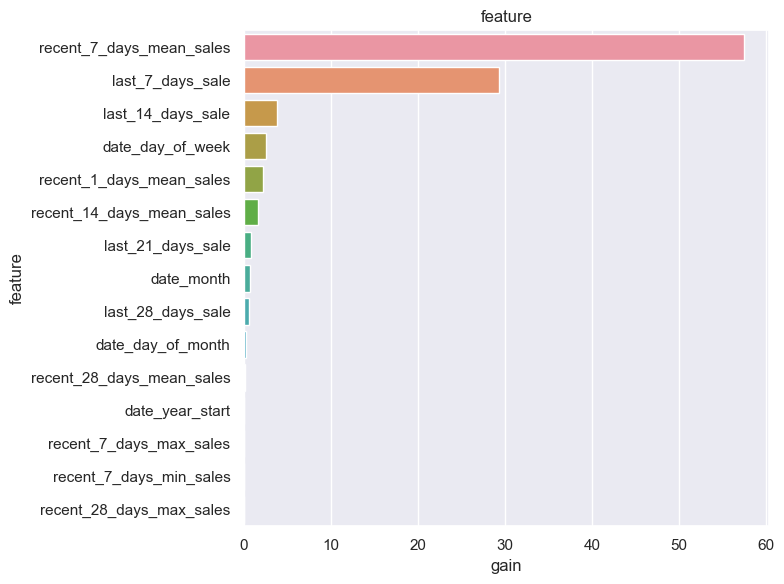

In [154]:
plot_lgb_importances(first_model, plot=True, num=15)

### SHAP

In [155]:
# explainer = shap.Explainer(first_model)
# shap_values_train = explainer(X_train)
# shap_values_valid = explainer(X_val)

# len(shap_values_train), len(shap_values_valid)

In [156]:
# # summarize the effects of all the features
# shap.plots.beeswarm(shap_values_train, max_display=30)

## Prediction

In [157]:
X_val.head()

,store,item,date_year,date_month,date_day_of_month,date_day_of_week,date_weekend,date_month_start,date_month_end,date_quarter_start,date_quarter_end,date_year_start,date_year_end,recent_1_days_mean_sales,recent_1_days_max_sales,recent_1_days_min_sales,recent_7_days_mean_sales,recent_7_days_max_sales,recent_7_days_min_sales,recent_14_days_mean_sales,recent_14_days_max_sales,recent_14_days_min_sales,recent_28_days_mean_sales,recent_28_days_max_sales,recent_28_days_min_sales,last_7_days_sale,last_14_days_sale,last_21_days_sale,last_28_days_sale,last_90_days_sale,last_180_days_sale
319500,5,23,2017,10,1,6,1,1,0,1,0,0,0,29.0,29.0,29.0,28.142857,40.0,16.0,25.785714,40.0,16.0,26.428571,42.0,16.0,40.0,30.0,42.0,30.0,25.0,20.0
319501,2,17,2017,10,1,6,1,1,0,1,0,0,0,47.0,47.0,47.0,46.428571,61.0,36.0,47.928571,61.0,36.0,48.964286,64.0,35.0,61.0,53.0,48.0,64.0,56.0,39.0
319502,5,45,2017,10,1,6,1,1,0,1,0,0,0,97.0,97.0,97.0,75.428571,98.0,60.0,76.357143,98.0,60.0,74.785714,98.0,58.0,78.0,89.0,84.0,92.0,62.0,63.0
319503,8,10,2017,10,1,6,1,1,0,1,0,0,0,103.0,103.0,103.0,103.857143,116.0,75.0,103.571429,126.0,74.0,104.035714,139.0,74.0,115.0,126.0,139.0,117.0,106.0,102.0
319504,10,38,2017,10,1,6,1,1,0,1,0,0,0,111.0,111.0,111.0,107.714286,126.0,89.0,106.571429,133.0,87.0,107.928571,142.0,87.0,118.0,112.0,131.0,132.0,112.0,80.0


In [158]:
X_val = X_val.assign(
    date=pd.to_datetime(
        df["date_year"].astype(str)
        + "-"
        + df["date_month"].astype(str)
        + "-"
        + df["date_day_of_month"].astype(str)
    )
)

In [159]:
df_prediction = pd.DataFrame(
    {
        "date": X_val["date"],
        "store": X_val["store"],
        "item":X_val["item"],
        "real_sales": Y_val,
        "pred_sales": first_model.predict(X_val.drop("date",axis=1)),
    }
)

In [160]:
df_prediction.head()

,date,store,item,real_sales,pred_sales
319500,2017-10-01,5,23,30.0,31.032403
319501,2017-10-01,2,17,45.0,53.095390
319502,2017-10-01,5,45,76.0,83.257157
319503,2017-10-01,8,10,133.0,115.526543
319504,2017-10-01,10,38,101.0,121.216680


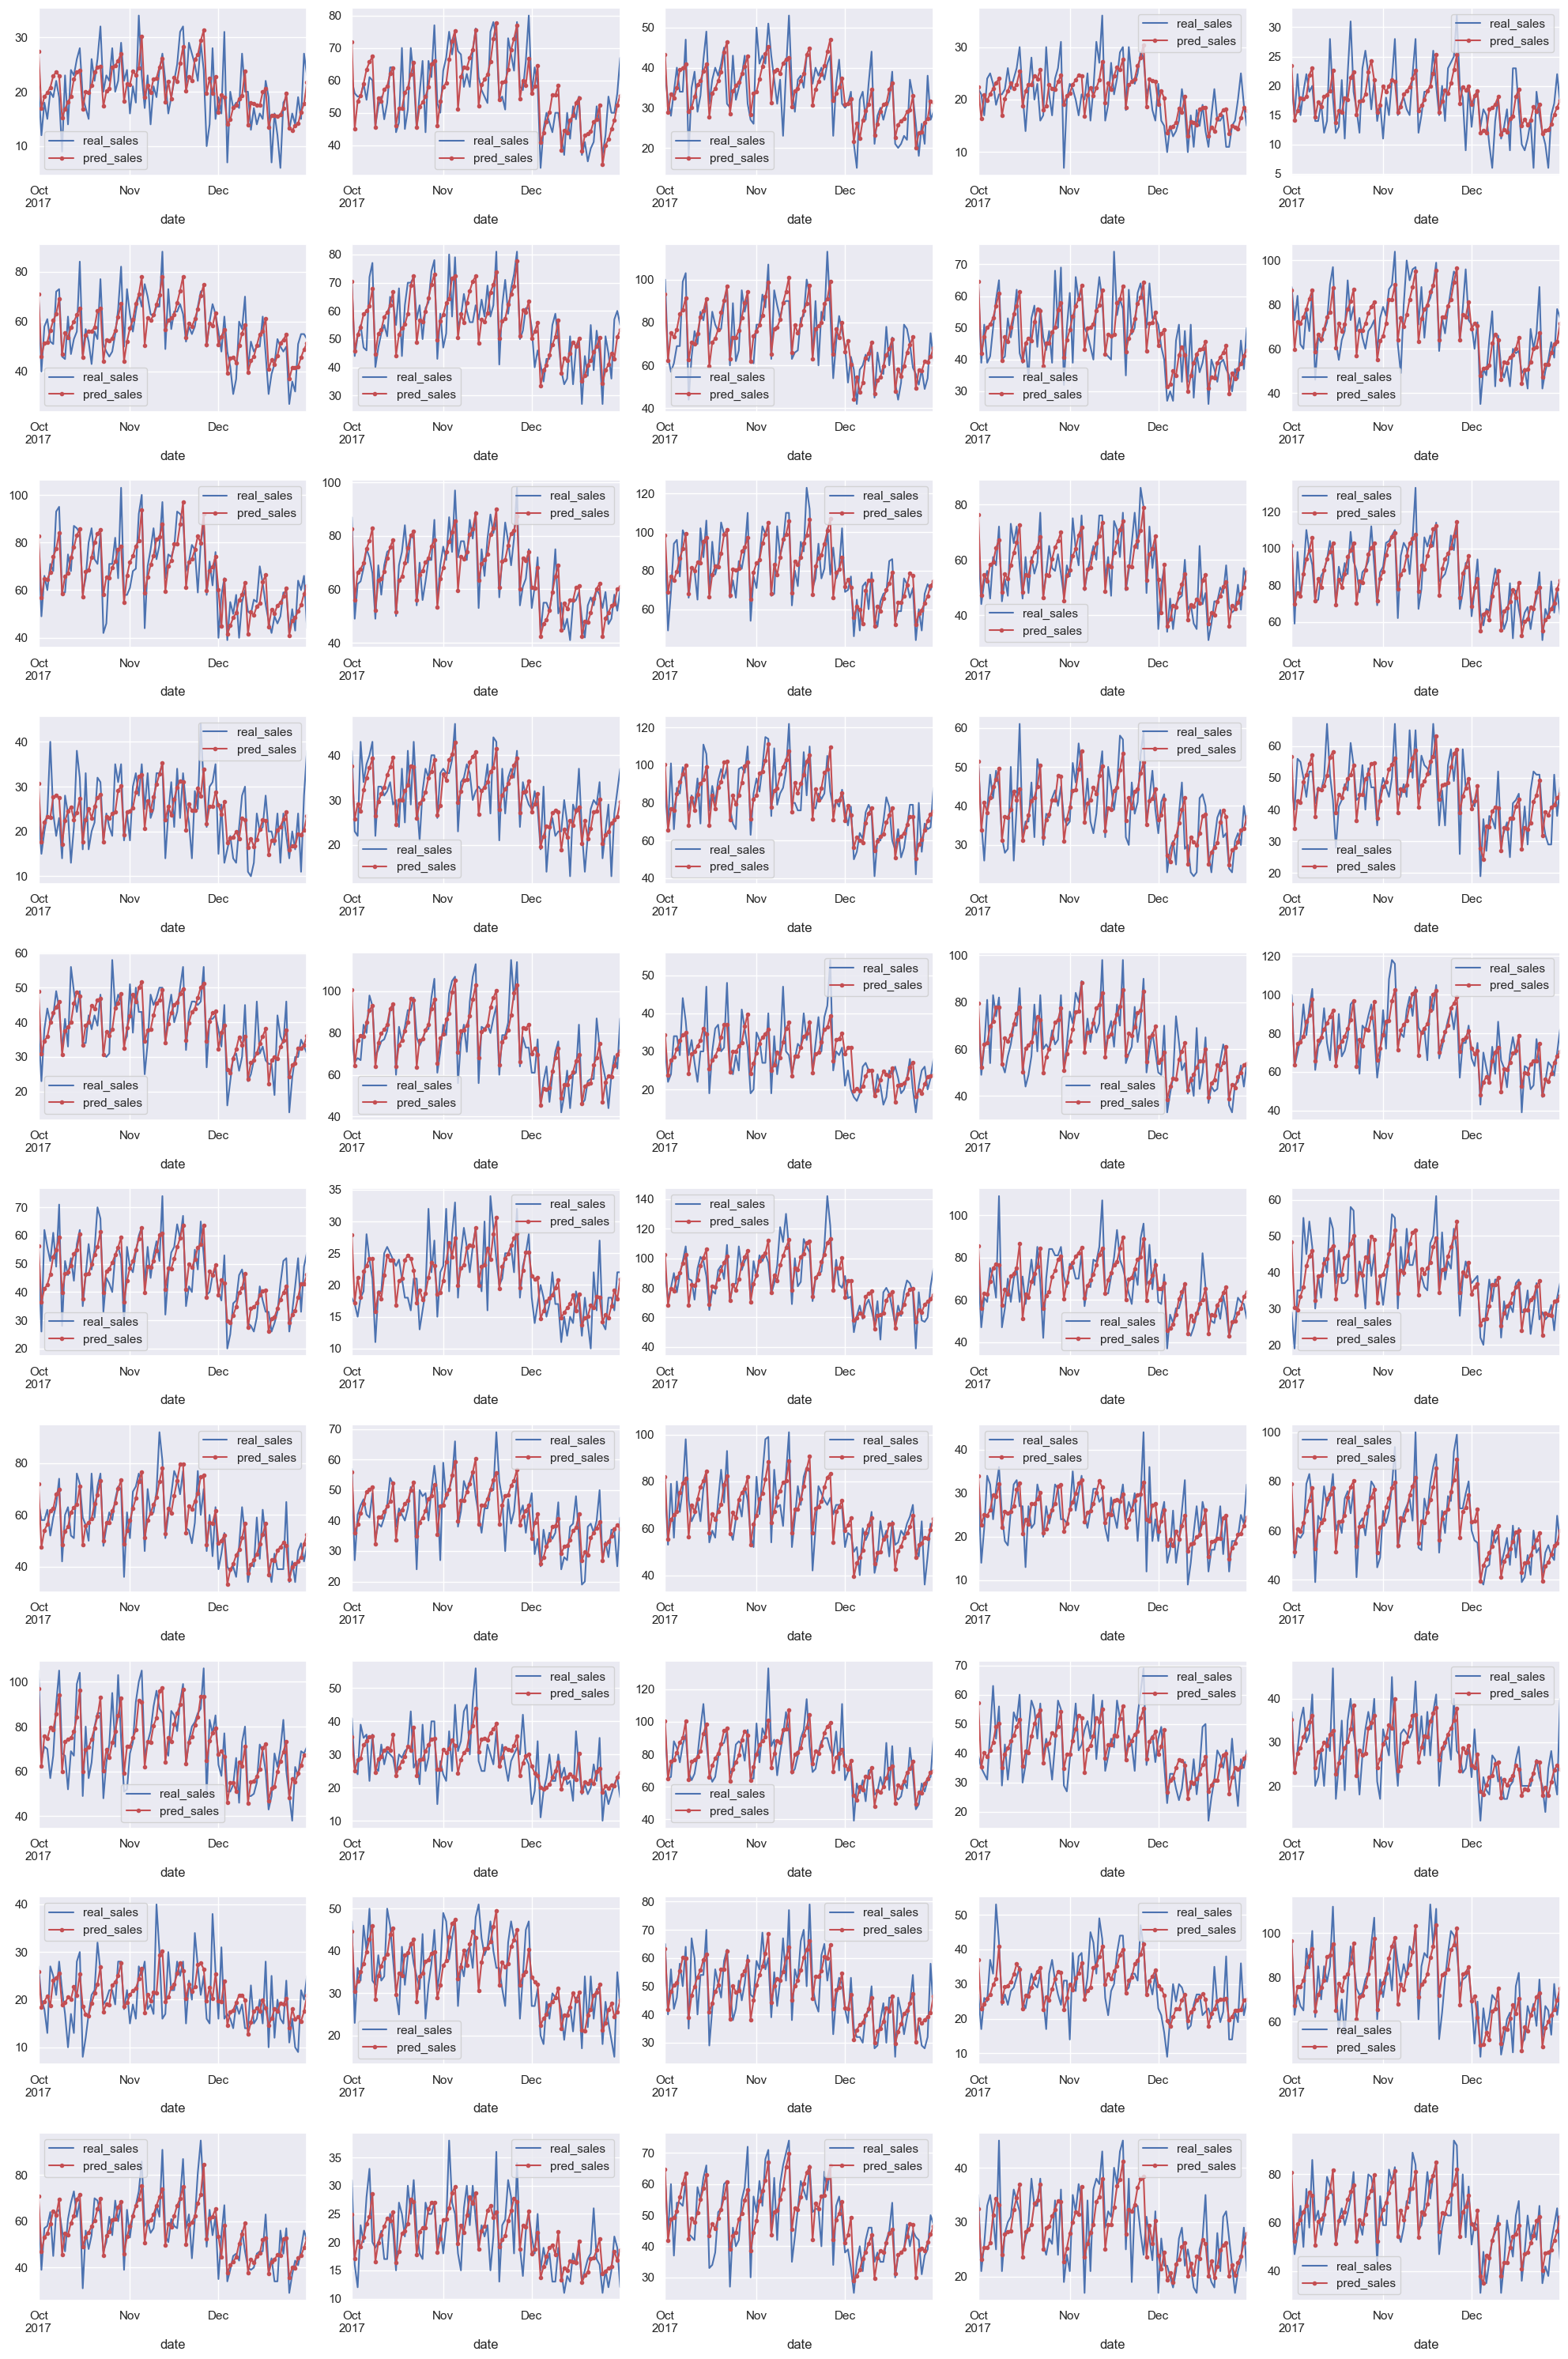

In [161]:
store_id = 1
# item_id = 10
df_sample = df_prediction.groupby(["store"]).get_group((store_id))

nrows=10
ncols=5
fig, axes = plt.subplots(nrows, ncols, figsize=(nrows*2, ncols*6))

for item_id, ax in zip(range(1,51), axes.flat):
    df2plot = df_sample.query("item==@item_id")
    df2plot[["date", "real_sales"]].plot(x="date", y="real_sales",ax=ax)
    df2plot[["date", "pred_sales"]].plot(x="date", y="pred_sales", marker="." ,c="r", ax=ax)

plt.tight_layout()